## Toxic Comment Classification Using Deep Learning

Study of negative online behaviour. We need to be able to classify text and discern between different levels of toxicity and disrespectful behaviour - such as like threats, obscenity, insults, and identity-based hate etc

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display

raw_data = pd.read_csv('../data/train.csv', encoding="utf-8")
display(raw_data.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Word2Vec

Vectorize the text

In [2]:
import nltk
import sklearn
import gensim
from nltk import word_tokenize, sent_tokenize
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE

class vectorizer(object):
    def __init__(self, vector_method, size, sg, window, min_count, seed, workers, sents):
        self._vector_method = vector_method
        self._size = size
        self._sg = sg
        self._window = window
        self._min_count = min_count
        self._seed = seed
        self._sents = sents
        self._workers = workers
        
    def vectorize_model(self):
        model = self._vector_method(sentences=self._sents, size=self._size, sg=self._sg,
                 window=self._window, min_count=self._min_count, seed=self._seed,
                 workers=self._workers)
        
        return model
        

In [3]:
# print(raw_data['comment_text'][:2])
from nltk.corpus import stopwords

def parse_sentences():
    sentences = []
    for index, row in raw_data.iterrows():
        text = row['comment_text']
        sent = list(sent_tokenize(text.lower()))
        sentences.append(sent)

    return sentences

def word_process(some_text):
    stop_words = set(stopwords.words('english'))    
    words = word_tokenize(some_text[0].lower())
    
    filtered_words = []
    for w in words:
        if w not in stop_words:
            filtered_words.append(w)
            
    return list(words) 

def parse_raw():
    documents = []
    sents = parse_sentences()
    for sent in sents:
        processed = word_process(sent)
        documents.append(processed)
    
    return documents

sentences = parse_raw()
# print(sentences)

word2vec_method = vectorizer(Word2Vec, 64, 1, 10, 3, 42, 2, sentences)
word2vec_model = word2vec_method.vectorize_model()
print('done processing')


done processing


In [4]:
# print(word2vec_model.wv.vocab)
# print(word2vec_model['fuck'])
print(word2vec_model.most_similar('fuck'))

[(u'vuvuzelas', 0.8352069854736328), (u'f***', 0.8057037591934204), (u'ruddy', 0.7962907552719116), (u'suppressing', 0.7875211238861084), (u'turd', 0.7871737480163574), (u'fuc*ing', 0.7819108366966248), (u'dianna', 0.7810384035110474), (u'fucky', 0.7785034775733948), (u'screw', 0.7777083516120911), (u'shyt', 0.7752842903137207)]


/Users/schumanzhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  app.launch_new_instance()


/Users/schumanzhang/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


          x         y    token
0 -1.816651 -3.138424    sonja
1  0.242851  2.773349     vani
2 -1.140752 -4.512937    woods
3 -2.895020 -0.001146  spiders
4 -0.311614  4.494462  hanging


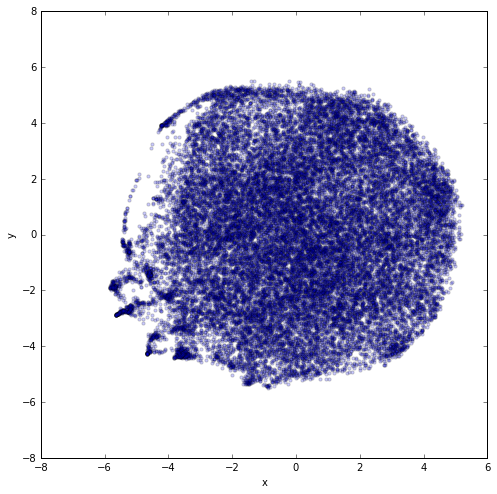

In [6]:
import matplotlib.pyplot as plt                        
%matplotlib inline

tsne = TSNE(n_components=2, n_iter=300)

X = word2vec_model[word2vec_model.wv.vocab]
X_2d = tsne.fit_transform(X)
coords_df = pd.DataFrame(X_2d, columns=['x', 'y'])
coords_df['token'] = word2vec_model.wv.vocab.keys()

print(coords_df.head())

# Plot the graph.
coords_df.plot.scatter('x', 'y', figsize=(8,8),
                       marker='o', s=10, alpha=0.2)

We define the features and labels

In [18]:
all_docs = list(raw_data['comment_text'])

print(all_docs[:2])
print(len(all_docs))

def collect_labels():
    targets = []
    for index, row in raw_data.iterrows():
        target = list(raw_data.iloc[index,2:])
        targets.append(target)
        
    return targets
        
all_labels = collect_labels()
print(all_labels[:2])

[u"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27", u"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"]
159571
[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]


In [102]:
import keras
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense, Flatten
from keras.callbacks import ModelCheckpoint

class neural_network(object):
    def __init__(self, docs, labels, epochs, batch_size, dropout):
        self._model = Sequential()
        self._docs = docs
        self._labels = labels
        self._epochs = epochs
        self._batch_size = batch_size
        self._dropout = dropout
     
    def split_data(self, docs, targets):
        length = len(docs)
        split_point = int(round(length * 0.8))
        return docs[:split_point], targets[:split_point], docs[split_point:], targets[split_point:]
        
    def prepare_docs(self, max_length):
        t = Tokenizer()
        t.fit_on_texts(self._docs)
        vocab_size = len(t.word_index) + 1
        encoded_docs = t.texts_to_sequences(self._docs)
        padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
        return padded_docs, t
    
    def calc_embedding_matrix(self, vocab_size, t):
        embedding_matrix = np.zeros((vocab_size, 64))
        for word, i in t.word_index.items():
            if word in word2vec_model.wv.vocab:
                embedding_vector = word2vec_model.wv[word]
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                
        return embedding_matrix
    
    def construct_model(self, vocab_size, max_length, embedding_matrix):
        
        embedding_layer = Embedding(vocab_size, 64, weights=[embedding_matrix], input_length=max_length)
        embedding_layer.trainable = False
        
        self._model.add(embedding_layer)
        self._model.add(Flatten())
        self._model.add(Dense(64, activation='relu'))
        self._model.add(Dropout(self._dropout))
        self._model.add(Dense(6, activation='sigmoid'))
        self._model.summary()
        
    def compile_model(self):
        self._model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        checkpointer = ModelCheckpoint(filepath='saved_models/weights.feed_forward_network.hdf5', 
                               verbose=1, save_best_only=True)
        
        return checkpointer
        
    def train_save_model(self, train_docs, train_targets, valid_docs, valid_targets, checkpointer):
        trained_model = self._model.fit(train_docs, train_targets, validation_data=(valid_docs, valid_targets), 
                          epochs=self._epochs, batch_size=self._batch_size, callbacks=[checkpointer], verbose=1)

        with open('pickles/feed_forward_network', 'wb') as file_pi:
            pickle.dump(trained_model.history, file_pi)
            
        return trained_model
            
    def get_model(self):
        return self._model

In [104]:
feed_forward_network = neural_network(all_docs, all_labels, 5, 128, 0.5)
padded_docs, t = feed_forward_network.prepare_docs(100)
print(padded_docs[:2])

[[  688    75     1   126   130   177    29   672  4511 12053  1116    86
    331    51  2278 11448    50  6864    15    60  2756   148     7  2937
     34   117  1221 15190  2825     4    45    59   244     1   365    31
      1    38    27   143    73  3462    89  3085  4583  2273   985     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [96144    52  2635    13   555  3809    73  4556  2706    21    94    38
    803  2679   992   589  8377   182     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0    

In [105]:
embedding_matrix = feed_forward_network.calc_embedding_matrix(len(t.word_index) + 1, t)
# print(embedding_matrix)

In [106]:
train_valid_docs, train_valid_targets, test_docs, test_targets = feed_forward_network.split_data(padded_docs, all_labels)
train_docs, train_targets, valid_docs, valid_targets = feed_forward_network.split_data(train_valid_docs, train_valid_targets)

In [107]:
feed_forward_network.construct_model(len(t.word_index) + 1, 100, embedding_matrix)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 64)           13460736  
_________________________________________________________________
flatten_5 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 390       
Total params: 13,870,790
Trainable params: 410,054
Non-trainable params: 13,460,736
_________________________________________________________________


In [108]:
checkpointer = feed_forward_network.compile_model()

In [109]:
trained_feed_forward_model = feed_forward_network.train_save_model(train_docs, train_targets, valid_docs, valid_targets, checkpointer)

Train on 102126 samples, validate on 25531 samples
Epoch 1/5
102126/102126 [==============================] - 17s 162us/step - loss: 0.0951 - acc: 0.9696 - val_loss: 0.0679 - val_acc: 0.9768
Epoch 2/5
102126/102126 [==============================] - 17s 162us/step - loss: 0.0694 - acc: 0.9756 - val_loss: 0.0657 - val_acc: 0.9773
Epoch 3/5
102126/102126 [==============================] - 16s 158us/step - loss: 0.0651 - acc: 0.9769 - val_loss: 0.0674 - val_acc: 0.9776
Epoch 4/5
102126/102126 [==============================] - 17s 162us/step - loss: 0.0620 - acc: 0.9774 - val_loss: 0.0672 - val_acc: 0.9773
Epoch 5/5
102126/102126 [==============================] - 16s 158us/step - loss: 0.0599 - acc: 0.9779 - val_loss: 0.0680 - val_acc: 0.9777
